# Philadelphia Housing Sale Price Predictor 

## Models 
Below are various models that will predict the sale price of homes in Philadelphia. The models Used are: 
- Linear Regression
- Decision Trees
- Random Forest 
- Gradeint Boosting 

## Data
Data is gathered from the city of philadelphia website for property data: https://www.phila.gov/property/data/

### Data Preprocessing 
Data from this dataset underwent extensive cleaning and preprocessing. Below are some of the main preprocessing techniques used to parse the data:
- Principle Component Analysis (PCA)
- One-hot Encoding 
- Binary Encoding 
- Inter-Quartile Range (IQR) 

# Importing and Analysing the dataset
below, I import the necessary libraries to process the data set and load in the dataset itself. I also perform some preliminary analysis on the data to get some basic statistics and the shape of the dataset. 

In [238]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns # advanced plotter 

raw_data = pd.read_csv(r'opa_properties_public.csv') 

# target is the sale_price attribute 
target = raw_data['sale_price']

print("\n\tData Statistics: ")
print(f"Data Shape: { raw_data.shape }")
#print(f"Statistics: { housing_data.describe }")

print("\n\tDataset Attributes:")
print(f"Attributes: {raw_data.columns}")



C:\Users\aaron\AppData\Local\Temp\ipykernel_18064\1581772330.py:6: DtypeWarning: Columns (5,26,49,77) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(r'opa_properties_public.csv')



	Data Statistics: 
Data Shape: (582933, 82)

	Dataset Attributes:
Attributes: Index(['the_geom', 'the_geom_webmercator', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition', 'fireplaces',
       'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition', 'location',
       'mailing_address_1', 'mailing_address_2', 'mailing_care_of',
       'mailing_city_state', 'mailing_street', 'mailing_zip', 'market_value',
       'market_value_date', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_stories', 'off_street_open',
       'other_building', 'owner_1', '

### Dropping Useless Attributes 

after sifting through the data there were many attributes that fit into the following categories:
- redundant (mailing_address_1 AND mailing_address_2 for example)
- uninformative (book_and_page, assesment_date etc.)

Some attributes were dropped due to the fact that they would simply add noise to the ML models those are given below: 
- street_name - dropped since streets may run all throughout the city and the same street may have homes of different prices 

In [239]:
# attributes to be dropped
to_drop = ['the_geom', 'assessment_date', 'beginning_point', 'book_and_page', 
    'category_code_description', 'cross_reference', 'house_number', 'location', 
    'mailing_address_1', 'mailing_address_2', 'mailing_care_of', 'mailing_city_state', 
    'mailing_street', 'market_value_date', 'the_geom_webmercator', 'other_building', 
    'owner_1', 'owner_2', 'parcel_number', 'recording_date',  'registry_number', 
    'unit', 'objectid', 'building_code', 'census_tract', 
    'date_exterior_condition', 'year_built_estimate', 'house_extension', 'mailing_zip', 
    'sewer', 'site_type', 'state_code', 'street_designation', 'street_name', 
    'street_direction', 'geographic_ward', 'parcel_shape', 'building_code_new', 'zoning', 
    'exempt_land', 'off_street_open', 'pin', 'sale_date', 'street_code', 
    'view_type', 'lat', 'lng', 'building_code_description', 'topography', 'census_tract']


# dropping the attributes and setting up our main 'data' dataframe 
data = raw_data.drop(to_drop, axis=1)


### Handling Missing Values and NaNs
 

first will look directly at our target attribute ('sale_price') and drop missing values from it. In this step, I will only handle the removal of...
- missing values
- place holder values (0 or 1)

In [240]:
# analyzing target attribute: sale_price 
print(f"Missing Values in Target: {target.isnull().sum()}") # 2534 missing values 

# dropping rows with missing 'sale_price' values 
data = data.dropna(subset=['sale_price'])

# checking if dataset has any place holders and dropping them 
place_holder_rows = data[data['sale_price'] <= 1]
print(f"Rows with sale Price as 1 or 0: {len(place_holder_rows)}") # 157670 rows

# dropping place holder values of 0 or 1 
data = data.drop(data[data.sale_price <= 1].index)



Missing Values in Target: 2534
Rows with sale Price as 1 or 0: 157670


Now, I'll gather some data about missing values in attrbiutes other than the target. I do this by generating some data and graphs about collumns with some amount of data missing. I feel that it is justified to drop rows from the dataset if the total amount of missing values in a given column is at most 5% of the the number of usable rows, that is i'll set my threshold to 5% of len(data).

Max Missing Data Threshold: 21136.45


Text(0, 0.5, 'Feature Name')

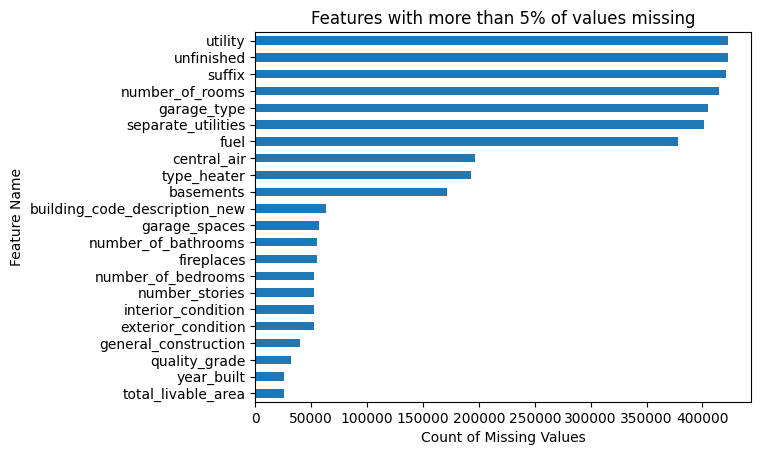

In [241]:
# graph of missing data attributes 
missing_data_threshold = 0.05 * len(data)
print(f"Max Missing Data Threshold: {missing_data_threshold}") # 5% of the data equates to roughly 20,500 rows 

missing = data.isnull().sum()
missing = missing[missing >= missing_data_threshold]
missing.sort_values(inplace=True)

missing.plot.barh() 
plt.title("""Features with more than 5% of values missing""")
plt.xlabel("Count of Missing Values")
plt.ylabel("Feature Name")

This bar chart provides some important insights. The most glaring of which are that attributes like 'utility', 'unfinished', 'suffix', 'number_of_rooms' etc. Have nearly **ALL** of their rows missing! I will need to either drop or impute these values as well as perform some analysis on their actual meanings as well. I will use these notes as a reference to the meaning of these attributes:

### Dropping Features With High Quantities of Missing Data

In [242]:
# selecting attributes to drop
attrs_exceed_missing = ['utility', 'unfinished', 'suffix', 'garage_type', 'number_of_rooms',
'separate_utilities', 'fuel', 'basements', 'central_air', 'type_heater', 'basements', 'building_code_description_new']

# dropping the attributes 
data = data.drop(attrs_exceed_missing, axis=1)


print(f"Total Columns Remaining: { data.shape[1] }")

Total Columns Remaining: 22


### Understanding the Features

_Category code_: the type of a particular building

| Code | Count  | Description       |
|------|--------|-------------------|
| 1    | 426976 | Single Family     |
| 6    | 44928  | Vacant Land       |
| 2    | 41538  | Multi Family      |
| 3    | 14489  | Mixed Use         |
| 4    | 13125  | Commercial        |
| 5    | 4286   | Industrial        |

I will only consider single family homes for the following reasons:
- they represent the majority of the data set (about 78%)
- vacant, industrial, commercial land is not relevant
- mixed use is vague (probably business and homes in same building)
- multi family is fairly small (roughly 10% of the homes) and difficult to interpret on a single household basis 





In [243]:
# keeping only single family designated homes  
data = data[data['category_code'] == 1]
print(len(data)) # 332307 homes remain 

340327


_Depth_: not clear what depth is - most likely depth of the home
the data is set to 0 at some points which seems to be a place holder and doesnt make sense (a house cant have a depth of 0). I will drop all rows with depth=0

In [244]:
# dropping all rows with a depth of 0
data = data.drop(data[data.depth == 0].index)
print(len(data)) # 305633

313087


_zip_code_: the zipcode of where the home is located. This will be treated as a categorical vairable (encoding will happen later after cleaning).
first zip codes in this dataset are given in the following format: `18974-0000`. We need to drop the hyphen. 
Also, I will look at the density of homes within each zip code and really only consider densly populated zip codes as they represent the cost of homes within the greater philadelphia area. 

In [245]:
# getting the number of zipcodes 
zip_codes = data.zip_code.value_counts(dropna=False)
print(f"Distinct Zip Codes: {len(zip_codes)}") # 47 zipcodes 
print(data['zip_code'].isnull().sum()) # only 7 rows with missing zip codes so we can drop

data = data.dropna(subset=['zip_code'])
    # formatting the zips 

# cutting everything after 5 chars and all strings 
new_zip_values = data['zip_code'].apply(lambda x: f"{int(str(x).strip()[:5]):05d}")

# converting to int and inserting into the zip_code col
data['zip_code'] = new_zip_values.astype('int64', errors='ignore')

print(f"Type of all zipcodes: {data['zip_code'].dtype}") # verifying this worked 


Distinct Zip Codes: 48
7
Type of all zipcodes: int64


_exterior_condition_ - this seems like an important metric to keep around since it doesnt have too many missing values and can reasonably expected to correlate with the sale price. The Following Codes are given for the designations: 

| Numerical Value | Category Label                           |
|-----------------|------------------------------------------|
| 0.0             | Not Applicable                           |
| 1.0             | New                          |
| 2.0             | Newer Construction / Rehabbed            |
| 3.0             | Above Average                            |
| 4.0             | Average                                  |
| 5.0             | Below Average                            |
| 6.0             | Vacant                                   |
| 7.0             | Sealed / Structurally Compromised        |




 I will then try to visualize the market value - exterior condition relationship with a box plot below: 

Number of Usable Rows: 313080


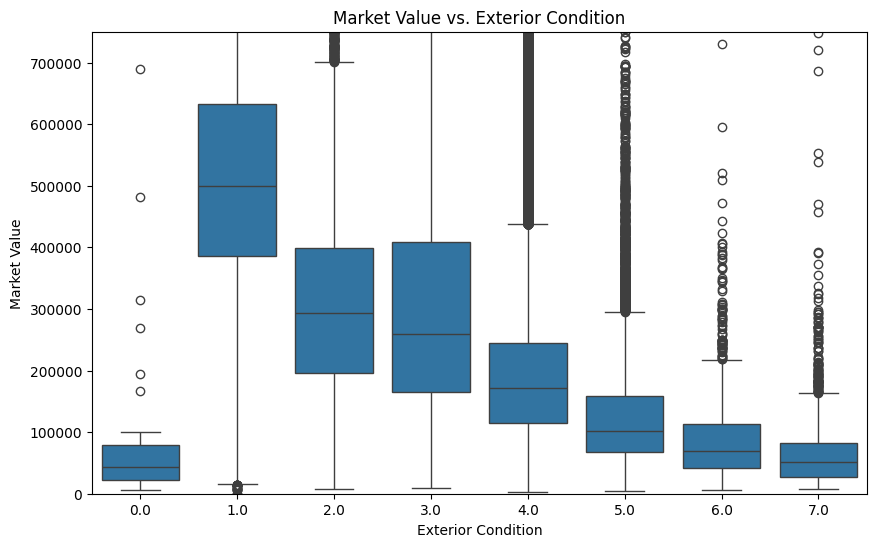

In [246]:
print(f"Number of Usable Rows: {len(data)}")

# making the box plot
plt.figure(figsize=(10, 6))  
sns.boxplot(x='exterior_condition', y='market_value', data=data)


# setting the limits so its easier to see the bars 
plt.ylim(0, 750000)

plt.title('Market Value vs. Exterior Condition')
plt.xlabel('Exterior Condition')
plt.ylabel('Market Value')
plt.show()

_interior_condition_: similarly, we can observe the trends of the interior condition with respect to market value 


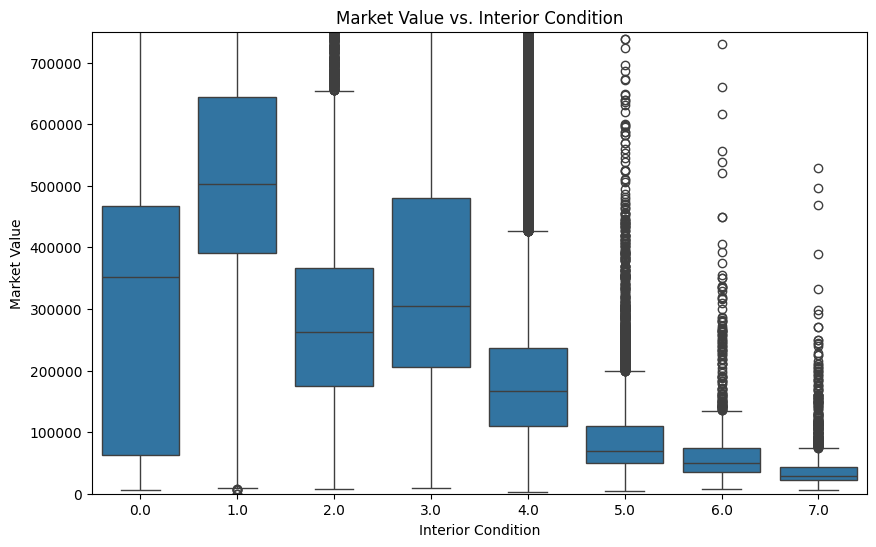

In [247]:

# making the box plot
plt.figure(figsize=(10, 6))  
sns.boxplot(x='interior_condition', y='market_value', data=data)


# setting the limits so its easier to see the bars 
plt.ylim(0, 750000)

plt.title('Market Value vs. Interior Condition')
plt.xlabel('Interior Condition')
plt.ylabel('Market Value')
plt.show()

I will drop all Nan Rows for interior_condition and exterior_condition 

In [248]:
# dropping Nans from these attributes 
data = data.dropna(subset=['exterior_condition'])
data = data.dropna(subset=['interior_condition'])

_quality_grade_ - the rating of quality of the home I will inspect the unique quality grades and count the missing values below.

Since the majority of the data exists within the valid_grades rating system I defined (a subset of all possible quality grades, I will just keep those). 
Since, after plotting a grade of 'C' is by far the most common rating, i feel it is reasonable to impute the 1325 missing values (Nans) with the grade of C. This makes intuitive sense since C corresponds to Average. 


Unique Quality Grades: ['B ' 'C ' 'C+' nan 'A-' 'D ' 'B+' 'A ' 'D+' 'D-' 'B-' 'C-' 'E+' 'E ' 'A+'
 '3 ' 'S ' 'E-' 'X-' '4 ' '5 ' '6 ' 'X ' 'S+' 'S-' 'X+']
NaN Quality Scores: 3881
Number of Grades in Logical Grading setup (A+, A, A-...): 308536


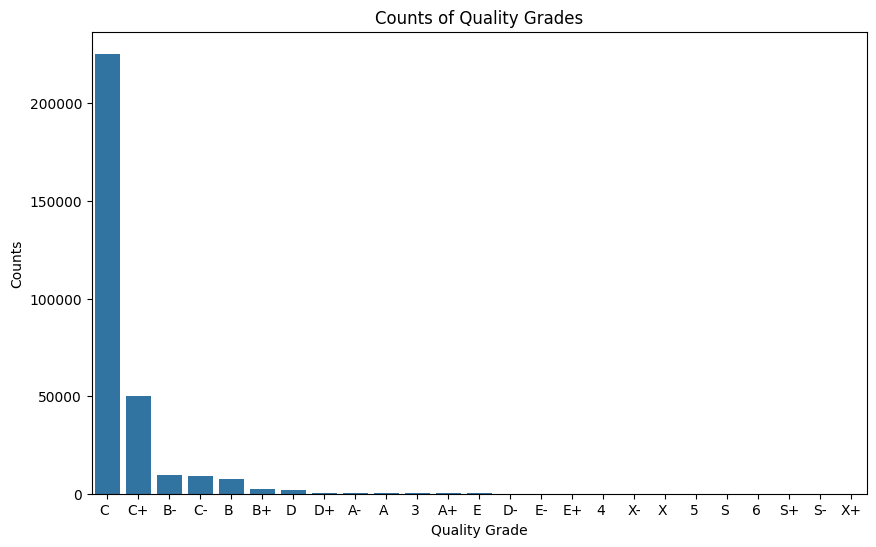

In [249]:
    # unique grades for quality_grade

# choosing grades that are interpretable
valid_grades = ['A+', 'A ', 'A-', 'B+', 'B ', 'B-', 'C+', 'C ', 'C-', 'D+', 'D ', 'D-', 'E+', 'E ']

# summing number of valid grades 
valid_grade_count = data['quality_grade'].isin(valid_grades).sum()

print(f"Unique Quality Grades: {data['quality_grade'].unique()}")
print(f"NaN Quality Scores: {data['quality_grade'].isnull().sum()}")
print(f"Number of Grades in Logical Grading setup (A+, A, A-...): {valid_grade_count}")

# counting values for all unique grades
grade_counts = data['quality_grade'].value_counts()

# plotting 
plt.figure(figsize=(10, 6))
sns.barplot(x=grade_counts.index, y=grade_counts.values)

plt.title('Counts of Quality Grades')
plt.xlabel('Quality Grade')
plt.ylabel('Counts')

plt.show()

Below, i will replace all quality grade values that are `Nan` with a 'C' and then drop those that arent in `valid_grades`

In [250]:
# imputing the to the Nans 
data['quality_grade'].fillna('C', inplace=True)

# dropping grades not in valid_grades
data = data[data['quality_grade'].isin(valid_grades)]
print(len(data))

# verify it worked 
print(data['quality_grade'].isnull().sum()) 

308536
0


C:\Users\aaron\AppData\Local\Temp\ipykernel_18064\1001785022.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['quality_grade'].fillna('C', inplace=True)


_category_code_ - this was used to determine the type of home a particular building was. I limit these models to only work with single family homes (Category code 1) so this feature was necessary for dropping non-single family homes. Now we will drop it since all values in the dataset have category code 1.

In [251]:
# dropping category code 
data = data.drop(columns=['category_code'])

### Nan Handling 

Above has been the majority of the work of dealing with dropping values, dealing with Nans and analyzing the data to get some preliminary results. The next part will involve feature engineering. As mentioned previously, some of the data contains placeholder values which will skew the ml models if left unaccoutned for. Usually values like 0 or 1 in features like total_area or year_built are meaningless and should be transformed into numpy nans. I will do this for the following attributes:
- depth
- total_area
- total_livable_area
- sale_price

In [252]:
featuers_with_place_holders = ['depth', 'total_area', 'total_livable_area', 'sale_price']

print('Before Place Holder Removal:')
for feature in featuers_with_place_holders:
    print(f"{feature} : {sorted(data[feature].unique())[:5]}")

print('\nAfter Place Holder Removal:')
# transforming placeholder values into nans 
for feature in featuers_with_place_holders:
    data[feature] = data[feature].replace(0, np.nan)
    data[feature] = data[feature].replace(1, np.nan)
    print(f"{feature} : {sorted(data[feature].unique())[:2]}")

Before Place Holder Removal:
depth : [1.0, 4.0, 5.0, 6.0, 8.0]
total_area : [0.0, 24.0, 49.0, 50.0, 52.0]
total_livable_area : [0.0, 1.0, 64.0, 125.0, 128.0]
sale_price : [2.0, 3.0, 4.0, 5.0, 6.0]

After Place Holder Removal:
depth : [4.0, 5.0]
total_area : [24.0, 49.0]
total_livable_area : [64.0, 128.0]
sale_price : [2.0, 3.0]


In [253]:
# final set of columns 
print(data.shape)
print(data.columns)

(308536, 21)
Index(['depth', 'exempt_building', 'exterior_condition', 'fireplaces',
       'frontage', 'garage_spaces', 'general_construction',
       'homestead_exemption', 'interior_condition', 'market_value',
       'number_of_bathrooms', 'number_of_bedrooms', 'number_stories',
       'quality_grade', 'sale_price', 'taxable_building', 'taxable_land',
       'total_area', 'total_livable_area', 'year_built', 'zip_code'],
      dtype='object')


### Imputing Missing Values
for the rest of the missing values, I will use the simple imputer from scikit-learn to impute the values. For these values, and based on the graphs above, I feel faily confident that doing a simple impuation using the median value for most of these items is logical. Things like quality/condition evaluations will tend towards average according to the data, and generally homes share similar numbers of bedrooms, bathrooms, etc. based on their size. 

first i will fill values that are not available in the dataset, this will be done on the following attributes:
- fireplaces
- garage_spaces

In [254]:
data['garage_space'] = data['garage_spaces'].fillna(0) # populating na valued rows for garage spaces with 0
data['fireplaces'] = data['fireplaces'].fillna(0) # likewise for fireplaces 

In [255]:
from sklearn.impute import SimpleImputer 
median_imputer = SimpleImputer(strategy='median') # creating an imputer to populate emptys with the median value 

# features for imputation
imputed_features = ['number_of_bathrooms', 'number_of_bedrooms', 
'number_stories', 'interior_condition', 'exterior_condition' , 
'year_built', 'total_livable_area', 'total_area', 'frontage', 
'taxable_building', 'exempt_building', 'depth', 'garage_spaces'] 


for feature in imputed_features:
    data[feature] = median_imputer.fit_transform(data[[feature]])
    print(feature)


number_of_bathrooms
number_of_bedrooms
number_stories
interior_condition
exterior_condition
year_built
total_livable_area
total_area
frontage
taxable_building
exempt_building
depth
garage_spaces


# Feature Engineering 
In this section, I will: 
- analyze correlations between attributes and the target (market value)
- impute missing values 
- encode data appropriately 
- scale the data
- standardize the data 
- perform outlier analysis and removal 

### Selecting and Encoding Categorical Data

Since i will need to see how categorical attributes also affect the data, well need to encode them. I have selected the following attributes by eliminating those that had large quantities of missing values and were not relevant (such as adresses and pin codes). 

- exterior_condition
- fireplaces
- general_construction 
- interior_condition
- quality_grade
- year_built

## Categorical Encodings
below I will define encodings for no numerical data, i will be using:
- One-Hot Encoding
- Binary Encoding
- Ordinal Encoding

I will separate the features into lists denoting what type of encoding these features will get

In [256]:
ordinal_encoding_features  = ['exterior_condition', 'interior_condition', 'quality_grade']
one_hot_encoding_features = ['general_construction']
binary_encoding_features = ['exempt_building', 'homestead_exemption']

### One-Hot Encoded Data
I will one-hot encode all features in the `one_hot_encdoing_features` column. Each one will be given a unique type of mapping based on the nature of the feature.

notes:
- exempt_building may be given as 0 for false, 1 for true so we must map that 
- exempt_land may function the same way as exempt_building except its 0.0 for some reason 
- homestead_exemption ahs cutoff of 80,000 for a TRUE exemption, 0 would be false 

In [270]:
# creating dummy vars 
data_one_hot = pd.get_dummies(data, columns=one_hot_encoding_features)

# homestead_exemption 
data_one_hot['homestead_exemption'] = data_one_hot['homestead_exemption'].map({80000: True, 0: False})
data_one_hot['homestead_exemption'] = data_one_hot['homestead_exemption'].fillna(False)

# exempt_building
data_one_hot['exempt_building'] = data_one_hot['exempt_building'].map({0: False}) 
data_one_hot['exempt_building'] = data_one_hot['exempt_building'].fillna(True)

# converting boolean encoded variables to their numeric representations 
boolean_features = data_one_hot.select_dtypes(include=bool).columns
data_one_hot[boolean_features] = data_one_hot[boolean_features].astype(int)

C:\Users\aaron\AppData\Local\Temp\ipykernel_18064\2973926357.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_one_hot['homestead_exemption'] = data_one_hot['homestead_exemption'].fillna(False)
C:\Users\aaron\AppData\Local\Temp\ipykernel_18064\2973926357.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_one_hot['exempt_building'] = data_one_hot['exempt_building'].fillna(True)


Lets do a final analysis on the 

### Ordinally Encoded Data
this data will be ordinally encoded as they are "grades" of quality 

In [258]:
from sklearn.preprocessing import OrdinalEncoder 

exterior_condition_grades = sorted(data['exterior_condition'].dropna().unique().astype(int))
interior_condition_grades = sorted(data['interior_condition'].dropna().unique().astype(int))

# exterior_condition_grades = sorted([exterior_condition_grades], reverse=True)
# interior_condition_grades = sorted([interior_condition_grades], reverse=True)


quality_grades = sorted(data['quality_grade'].unique())

# encdoing exterior condition 
exterior_condition_encoder = OrdinalEncoder(categories=[exterior_condition_grades])
data['exterior_condition_encoded'] = exterior_condition_encoder.fit_transform(data[['exterior_condition']])

# encdoing interior condition 
interior_condition_encoder = OrdinalEncoder(categories=[interior_condition_grades])
data['interior_condition_encoded'] = interior_condition_encoder.fit_transform(data[['interior_condition']])

# encoding quality grade 
quality_grade_encoder = OrdinalEncoder(categories=[quality_grades])
data['quality_grades_encoded'] = quality_grade_encoder.fit_transform(data[['quality_grade']])


### Outlier Handling 

##### Handling Market Value
as this is the target variable, id like to section it off from the rest of the features

In [259]:
# setting bounds
market_value_bounds = [100, 2000000] # 100 < mv < 2,000,000 

data = data[(data['market_value'] >= market_value_bounds[0]) & (data['market_value'] <= market_value_bounds[1])]


##### Independent Features

After analysis of the data, I set hard limits based on the counts and ragnes of values for each numerical attribute. This is due to the overwheling majority of the data being in a given range and only a small percentage (roughly 1-2%) skewing right in the features below. I therefore only kept the mean features and essentially arrived at a normal distribution. I used the VScode Data Wrangler to roughly calculate an IQR for the data set and set the bounds accordingly. 

In [260]:
# feature bounds
depth_bounds = [10, 400]
frontage_bounds = [0, 70]
garage_bounds = [0, 3]
number_of_bathrooms_bounds = [0, 6]
number_of_bedrooms_bounds = [0, 6]
number_of_stories_bounds = [0, 5]
taxable_building_bounds = [0, 1000000]
taxable_land_bounds = [0, 2000000]
total_area_bounds = [0, 17000]
total_livable_area_bounds = [0, 10000]
year_built_bounds = [1900, 2024]

# dropping outliers 
data = data[(data['depth'] >= depth_bounds[0]) & (data['depth'] <= depth_bounds[1])]
data = data[(data['frontage'] >= frontage_bounds[0]) & (data['frontage'] <= frontage_bounds[1])]
data = data[(data['garage_spaces'] >= garage_bounds[0]) & (data['garage_spaces'] <= garage_bounds[1])]
data = data[(data['number_of_bathrooms'] >= number_of_bathrooms_bounds[0]) & (data['number_of_bathrooms'] <= number_of_bathrooms_bounds[1])]
data = data[(data['number_of_bedrooms'] >= number_of_bedrooms_bounds[0]) & (data['number_of_bedrooms'] <= number_of_bedrooms_bounds[1])]
data = data[(data['number_stories'] >= number_of_stories_bounds[0]) & (data['number_stories'] <= number_of_stories_bounds[1])]
data = data[(data['taxable_building'] >= taxable_building_bounds[0]) & (data['taxable_building'] <= taxable_building_bounds[1])]
data = data[(data['taxable_land'] >= taxable_land_bounds[0]) & (data['taxable_land'] <= taxable_land_bounds[1])]
data = data[(data['total_area'] >= total_area_bounds[0]) & (data['total_area'] <= total_area_bounds[1])]
data = data[(data['total_livable_area'] >= total_livable_area_bounds[0]) & (data['total_livable_area'] <= total_livable_area_bounds[1])]
data = data[(data['year_built'] >= year_built_bounds[0]) & (data['year_built'] <= year_built_bounds[1])]

In [261]:
# Q1 = y.quantile(0.25)
# Q3 = y.quantile(0.75)
# IQR = Q3 - Q1

# # iqr thresholds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR


In [262]:
numerical_data = data.select_dtypes(include=['number'])
market_value_correlation = numerical_data.corr()
market_value_correlation.sort_values(['market_value'], ascending=False, inplace=True)

print("Correlation Values for Each Numerical Attribute to the Target:\n")
print(market_value_correlation.market_value)


Correlation Values for Each Numerical Attribute to the Target:

market_value                  1.000000
taxable_land                  0.983586
taxable_building              0.752590
total_livable_area            0.583850
exempt_building               0.506906
year_built                    0.399955
frontage                      0.298338
total_area                    0.266137
number_stories                0.261163
fireplaces                    0.236299
number_of_bathrooms           0.224582
garage_space                  0.165151
garage_spaces                 0.165151
depth                         0.127068
homestead_exemption           0.125794
sale_price                    0.032455
zip_code                     -0.048434
number_of_bedrooms           -0.068683
quality_grades_encoded       -0.221437
exterior_condition           -0.438742
exterior_condition_encoded   -0.438742
interior_condition           -0.480197
interior_condition_encoded   -0.480197
Name: market_value, dtype: float64


In [263]:
# dropping things with less than 15% correlation to market value 
df_correlated = market_value_correlation["market_value"]
f_columns = df_correlated[abs(mv_correlations) > 0.15].index  

df_filtered = data[f_columns] 

NameError: name 'mv_correlations' is not defined

### Final Analysis
After working with the data, we are now able to see the final count of missing values that need to be corrected. Below are some results that im happy with so i will now begin. To train my models 

In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data)

# final drop of nans
data = data.dropna() 


                            Total   Percent
building_code_description       0  0.000990
number_stories                  0  0.000000
interior_condition_encoded      0  0.000000
exterior_condition_encoded      0  0.000000
zip_code                        0  0.000000
year_built                      0  0.000000
total_livable_area              0  0.000000
total_area                      0  0.000000
taxable_land                    0  0.000000
taxable_building                0  0.000330
sale_price                      0  0.000000
quality_grade                   0  0.000000
number_of_bedrooms              0  0.000000
category_code                   0  0.000000
number_of_bathrooms             0  0.000000
market_value                    0  0.000000
interior_condition              0  0.000000
homestead_exemption             0  0.000000
garage_spaces                   0  0.000000
frontage                        0  0.000000
fireplaces                      0  0.036941
exterior_condition              

In [ ]:
# final count of columns 
print(data.shape)

(303067, 25)


# Model Construction 
now we move on to building the models. 

Final feature set: 

features = ['depth', 'exempt_building', 'exterior_condition_encoded', 'fireplaces', 
            'frontage', 'garage_spaces', 'homestead_exemption', 'interior_condition_encoded', 
            'number_of_bathrooms', 'number_of_bedrooms', 'number_stories', 
            'quality_grades_encoded', 'taxable_building', 'taxable_land', 'total_area', 
            'total_livable_area', 'year_built', 'zip_code']


### Linear Regression 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming df_filtered is your DataFrame and 'market_value' is the target

# Remove rows with NaN values in any column
df_filtered_clean = df_filtered.dropna()

# Selecting features and target
features = df_filtered_clean.drop(columns=['market_value'])
y = df_filtered_clean['market_value']

# Scaling features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.2, random_state=42)

# Creating the Linear Regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting the target values for the test set
y_pred = model.predict(X_test)

# Calculating the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f"R^2: {r2}")

Mean Squared Error: 9595893.208830014
R^2: 0.9996508048412591


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Create a Decision Tree model
dt_model = DecisionTreeRegressor(random_state=5)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
dt_predictions = dt_model.predict(X_test)

# Evaluate the model
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
print(f'Decision Tree - Mean Squared Error: {dt_mse}')
print(f'Decision Tree - R2 Score: {dt_r2}')


Decision Tree - Mean Squared Error: 29803358.630019467
Decision Tree - R2 Score: 0.998915453900816


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=5)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print(f'Random Forest - Mean Squared Error: {rf_mse}')
print(f'Random Forest - R2 Score: {rf_r2}')


Random Forest - Mean Squared Error: 20217389.53265638
Random Forest - R2 Score: 0.9992642879205151
